In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


Loaded 78017 images
Dataset type test label type: species


Loaded 81589 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 oo98862g


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-oo98862g:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1186 [00:00<10:50,  1.82it/s]

  0%|▌                                                                                                                                         | 5/1186 [00:00<02:02,  9.66it/s]

  1%|█▏                                                                                                                                       | 10/1186 [00:00<01:04, 18.16it/s]

  1%|█▋                                                                                                                                       | 15/1186 [00:00<00:47, 24.80it/s]

  2%|██▎                                                                                                                                      | 20/1186 [00:00<00:38, 29.90it/s]

  2%|██▉                                                                                                                                      | 25/1186 [00:01<00:34, 33.68it/s]

  3%|███▍                                                                                                                                     | 30/1186 [00:01<00:31, 36.45it/s]

  3%|████                                                                                                                                     | 35/1186 [00:01<00:29, 38.41it/s]

  3%|████▌                                                                                                                                    | 40/1186 [00:01<00:28, 39.80it/s]

  4%|█████▏                                                                                                                                   | 45/1186 [00:01<00:27, 40.79it/s]

  4%|█████▊                                                                                                                                   | 50/1186 [00:01<00:27, 41.54it/s]

  5%|██████▎                                                                                                                                  | 55/1186 [00:01<00:26, 42.17it/s]

  5%|██████▉                                                                                                                                  | 60/1186 [00:01<00:26, 42.58it/s]

  5%|███████▌                                                                                                                                 | 65/1186 [00:02<00:26, 42.88it/s]

  6%|████████                                                                                                                                 | 70/1186 [00:02<00:25, 43.11it/s]

  6%|████████▋                                                                                                                                | 75/1186 [00:02<00:25, 43.25it/s]

  7%|█████████▏                                                                                                                               | 80/1186 [00:02<00:25, 43.31it/s]

  7%|█████████▊                                                                                                                               | 85/1186 [00:02<00:25, 43.40it/s]

  8%|██████████▍                                                                                                                              | 90/1186 [00:02<00:25, 43.45it/s]

  8%|██████████▉                                                                                                                              | 95/1186 [00:02<00:25, 43.49it/s]

  8%|███████████▍                                                                                                                            | 100/1186 [00:02<00:24, 43.52it/s]

  9%|████████████                                                                                                                            | 105/1186 [00:02<00:24, 43.55it/s]

  9%|████████████▌                                                                                                                           | 110/1186 [00:03<00:24, 43.31it/s]

 10%|█████████████▏                                                                                                                          | 115/1186 [00:03<00:24, 43.40it/s]

 10%|█████████████▊                                                                                                                          | 120/1186 [00:03<00:24, 43.46it/s]

 11%|██████████████▎                                                                                                                         | 125/1186 [00:03<00:24, 43.49it/s]

 11%|██████████████▉                                                                                                                         | 130/1186 [00:03<00:24, 43.52it/s]

 11%|███████████████▍                                                                                                                        | 135/1186 [00:03<00:24, 43.55it/s]

 12%|████████████████                                                                                                                        | 140/1186 [00:03<00:24, 43.56it/s]

 12%|████████████████▋                                                                                                                       | 145/1186 [00:03<00:23, 43.57it/s]

 13%|█████████████████▏                                                                                                                      | 150/1186 [00:03<00:23, 43.58it/s]

 13%|█████████████████▊                                                                                                                      | 155/1186 [00:04<00:23, 43.59it/s]

 13%|██████████████████▎                                                                                                                     | 160/1186 [00:04<00:23, 43.60it/s]

 14%|██████████████████▉                                                                                                                     | 165/1186 [00:04<00:23, 43.58it/s]

 14%|███████████████████▍                                                                                                                    | 170/1186 [00:04<00:23, 43.60it/s]

 15%|████████████████████                                                                                                                    | 175/1186 [00:04<00:23, 43.58it/s]

 15%|████████████████████▋                                                                                                                   | 180/1186 [00:04<00:23, 43.60it/s]

 16%|█████████████████████▏                                                                                                                  | 185/1186 [00:04<00:22, 43.61it/s]

 16%|█████████████████████▊                                                                                                                  | 190/1186 [00:04<00:22, 43.61it/s]

 16%|██████████████████████▎                                                                                                                 | 195/1186 [00:05<00:22, 43.62it/s]

 17%|██████████████████████▉                                                                                                                 | 200/1186 [00:05<00:22, 43.60it/s]

 17%|███████████████████████▌                                                                                                                | 205/1186 [00:05<00:22, 43.61it/s]

 18%|████████████████████████                                                                                                                | 210/1186 [00:05<00:22, 43.63it/s]

 18%|████████████████████████▋                                                                                                               | 215/1186 [00:05<00:22, 43.63it/s]

 19%|█████████████████████████▏                                                                                                              | 220/1186 [00:05<00:22, 43.64it/s]

 19%|█████████████████████████▊                                                                                                              | 225/1186 [00:05<00:22, 43.62it/s]

 19%|██████████████████████████▎                                                                                                             | 230/1186 [00:05<00:21, 43.62it/s]

 20%|██████████████████████████▉                                                                                                             | 235/1186 [00:05<00:21, 43.63it/s]

 20%|███████████████████████████▌                                                                                                            | 240/1186 [00:06<00:21, 43.62it/s]

 21%|████████████████████████████                                                                                                            | 245/1186 [00:06<00:21, 43.63it/s]

 21%|████████████████████████████▋                                                                                                           | 250/1186 [00:06<00:21, 43.58it/s]

 22%|█████████████████████████████▏                                                                                                          | 255/1186 [00:06<00:21, 43.61it/s]

 22%|█████████████████████████████▊                                                                                                          | 260/1186 [00:06<00:21, 43.61it/s]

 22%|██████████████████████████████▍                                                                                                         | 265/1186 [00:06<00:21, 43.61it/s]

 23%|██████████████████████████████▉                                                                                                         | 270/1186 [00:06<00:21, 43.60it/s]

 23%|███████████████████████████████▌                                                                                                        | 275/1186 [00:06<00:20, 43.62it/s]

 24%|████████████████████████████████                                                                                                        | 280/1186 [00:06<00:20, 43.63it/s]

 24%|████████████████████████████████▋                                                                                                       | 285/1186 [00:07<00:20, 43.62it/s]

 24%|█████████████████████████████████▎                                                                                                      | 290/1186 [00:07<00:20, 43.61it/s]

 25%|█████████████████████████████████▊                                                                                                      | 295/1186 [00:07<00:20, 43.63it/s]

 25%|██████████████████████████████████▍                                                                                                     | 300/1186 [00:07<00:20, 43.64it/s]

 26%|██████████████████████████████████▉                                                                                                     | 305/1186 [00:07<00:20, 43.65it/s]

 26%|███████████████████████████████████▌                                                                                                    | 310/1186 [00:07<00:20, 43.65it/s]

 27%|████████████████████████████████████                                                                                                    | 315/1186 [00:07<00:19, 43.65it/s]

 27%|████████████████████████████████████▋                                                                                                   | 320/1186 [00:07<00:19, 43.62it/s]

 27%|█████████████████████████████████████▎                                                                                                  | 325/1186 [00:08<00:19, 43.62it/s]

 28%|█████████████████████████████████████▊                                                                                                  | 330/1186 [00:08<00:19, 43.61it/s]

 28%|██████████████████████████████████████▍                                                                                                 | 335/1186 [00:08<00:19, 43.60it/s]

 29%|██████████████████████████████████████▉                                                                                                 | 340/1186 [00:08<00:19, 43.61it/s]

 29%|███████████████████████████████████████▌                                                                                                | 345/1186 [00:08<00:19, 43.64it/s]

 30%|████████████████████████████████████████▏                                                                                               | 350/1186 [00:08<00:19, 43.64it/s]

 30%|████████████████████████████████████████▋                                                                                               | 355/1186 [00:08<00:19, 43.63it/s]

 30%|█████████████████████████████████████████▎                                                                                              | 360/1186 [00:08<00:18, 43.60it/s]

 31%|█████████████████████████████████████████▊                                                                                              | 365/1186 [00:08<00:18, 43.61it/s]

 31%|██████████████████████████████████████████▍                                                                                             | 370/1186 [00:09<00:18, 43.60it/s]

 32%|███████████████████████████████████████████                                                                                             | 375/1186 [00:09<00:18, 43.60it/s]

 32%|███████████████████████████████████████████▌                                                                                            | 380/1186 [00:09<00:18, 43.62it/s]

 32%|████████████████████████████████████████████▏                                                                                           | 385/1186 [00:09<00:18, 43.63it/s]

 33%|████████████████████████████████████████████▋                                                                                           | 390/1186 [00:09<00:18, 43.62it/s]

 33%|█████████████████████████████████████████████▎                                                                                          | 395/1186 [00:09<00:18, 43.62it/s]

 34%|█████████████████████████████████████████████▊                                                                                          | 400/1186 [00:09<00:18, 43.61it/s]

 34%|██████████████████████████████████████████████▍                                                                                         | 405/1186 [00:09<00:17, 43.58it/s]

 35%|███████████████████████████████████████████████                                                                                         | 410/1186 [00:09<00:17, 43.59it/s]

 35%|███████████████████████████████████████████████▌                                                                                        | 415/1186 [00:10<00:17, 43.62it/s]

 35%|████████████████████████████████████████████████▏                                                                                       | 420/1186 [00:10<00:17, 43.62it/s]

 36%|████████████████████████████████████████████████▋                                                                                       | 425/1186 [00:10<00:17, 43.62it/s]

 36%|█████████████████████████████████████████████████▎                                                                                      | 430/1186 [00:10<00:17, 43.61it/s]

 37%|█████████████████████████████████████████████████▉                                                                                      | 435/1186 [00:10<00:17, 43.62it/s]

 37%|██████████████████████████████████████████████████▍                                                                                     | 440/1186 [00:10<00:17, 43.63it/s]

 38%|███████████████████████████████████████████████████                                                                                     | 445/1186 [00:10<00:16, 43.64it/s]

 38%|███████████████████████████████████████████████████▌                                                                                    | 450/1186 [00:10<00:16, 43.62it/s]

 38%|████████████████████████████████████████████████████▏                                                                                   | 455/1186 [00:10<00:16, 43.58it/s]

 39%|████████████████████████████████████████████████████▋                                                                                   | 460/1186 [00:11<00:16, 43.57it/s]

 39%|█████████████████████████████████████████████████████▎                                                                                  | 465/1186 [00:11<00:16, 43.60it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                  | 470/1186 [00:11<00:16, 43.61it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                 | 475/1186 [00:11<00:16, 43.63it/s]

 40%|███████████████████████████████████████████████████████                                                                                 | 480/1186 [00:11<00:16, 43.63it/s]

 41%|███████████████████████████████████████████████████████▌                                                                                | 485/1186 [00:11<00:16, 43.62it/s]

 41%|████████████████████████████████████████████████████████▏                                                                               | 490/1186 [00:11<00:15, 43.59it/s]

 42%|████████████████████████████████████████████████████████▊                                                                               | 495/1186 [00:11<00:15, 43.61it/s]

 42%|█████████████████████████████████████████████████████████▎                                                                              | 500/1186 [00:12<00:15, 43.63it/s]

 43%|█████████████████████████████████████████████████████████▉                                                                              | 505/1186 [00:12<00:15, 43.64it/s]

 43%|██████████████████████████████████████████████████████████▍                                                                             | 510/1186 [00:12<00:15, 43.59it/s]

 43%|███████████████████████████████████████████████████████████                                                                             | 515/1186 [00:12<00:15, 43.59it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                            | 520/1186 [00:12<00:15, 43.60it/s]

 44%|████████████████████████████████████████████████████████████▏                                                                           | 525/1186 [00:12<00:15, 43.60it/s]

 45%|████████████████████████████████████████████████████████████▊                                                                           | 530/1186 [00:12<00:15, 43.61it/s]

 45%|█████████████████████████████████████████████████████████████▎                                                                          | 535/1186 [00:12<00:14, 43.63it/s]

 46%|█████████████████████████████████████████████████████████████▉                                                                          | 540/1186 [00:12<00:14, 43.64it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                         | 545/1186 [00:13<00:14, 43.64it/s]

 46%|███████████████████████████████████████████████████████████████                                                                         | 550/1186 [00:13<00:14, 43.64it/s]

 47%|███████████████████████████████████████████████████████████████▋                                                                        | 555/1186 [00:13<00:14, 43.63it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                       | 560/1186 [00:13<00:14, 43.63it/s]

 48%|████████████████████████████████████████████████████████████████▊                                                                       | 565/1186 [00:13<00:14, 43.62it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 570/1186 [00:13<00:14, 43.64it/s]

 48%|█████████████████████████████████████████████████████████████████▉                                                                      | 575/1186 [00:13<00:14, 42.80it/s]

 49%|██████████████████████████████████████████████████████████████████▌                                                                     | 580/1186 [00:13<00:14, 43.05it/s]

 49%|███████████████████████████████████████████████████████████████████                                                                     | 585/1186 [00:13<00:13, 43.23it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                    | 590/1186 [00:14<00:13, 43.35it/s]

 50%|████████████████████████████████████████████████████████████████████▏                                                                   | 595/1186 [00:14<00:13, 43.44it/s]

 51%|████████████████████████████████████████████████████████████████████▊                                                                   | 600/1186 [00:14<00:13, 43.51it/s]

 51%|█████████████████████████████████████████████████████████████████████▍                                                                  | 605/1186 [00:14<00:13, 43.55it/s]

 51%|█████████████████████████████████████████████████████████████████████▉                                                                  | 610/1186 [00:14<00:13, 43.57it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                 | 615/1186 [00:14<00:13, 43.60it/s]

 52%|███████████████████████████████████████████████████████████████████████                                                                 | 620/1186 [00:14<00:12, 43.59it/s]

 53%|███████████████████████████████████████████████████████████████████████▋                                                                | 625/1186 [00:14<00:12, 43.61it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                               | 630/1186 [00:15<00:12, 43.61it/s]

 54%|████████████████████████████████████████████████████████████████████████▊                                                               | 635/1186 [00:15<00:12, 43.62it/s]

 54%|█████████████████████████████████████████████████████████████████████████▍                                                              | 640/1186 [00:15<00:12, 43.63it/s]

 54%|█████████████████████████████████████████████████████████████████████████▉                                                              | 645/1186 [00:15<00:12, 43.63it/s]

 55%|██████████████████████████████████████████████████████████████████████████▌                                                             | 650/1186 [00:15<00:12, 43.58it/s]

 55%|███████████████████████████████████████████████████████████████████████████                                                             | 655/1186 [00:15<00:12, 43.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████▋                                                            | 660/1186 [00:15<00:12, 43.60it/s]

 56%|████████████████████████████████████████████████████████████████████████████▎                                                           | 665/1186 [00:15<00:11, 43.61it/s]

 56%|████████████████████████████████████████████████████████████████████████████▊                                                           | 670/1186 [00:15<00:11, 43.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▍                                                          | 675/1186 [00:16<00:11, 43.64it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▉                                                          | 680/1186 [00:16<00:11, 43.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▌                                                         | 685/1186 [00:16<00:11, 43.65it/s]

 58%|███████████████████████████████████████████████████████████████████████████████                                                         | 690/1186 [00:16<00:11, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▋                                                        | 695/1186 [00:16<00:11, 43.63it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▎                                                       | 700/1186 [00:16<00:11, 43.62it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▊                                                       | 705/1186 [00:16<00:11, 43.62it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▍                                                      | 710/1186 [00:16<00:10, 43.63it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                      | 715/1186 [00:16<00:10, 43.64it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▌                                                     | 720/1186 [00:17<00:10, 43.64it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                    | 725/1186 [00:17<00:10, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▋                                                    | 730/1186 [00:17<00:10, 43.58it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                   | 735/1186 [00:17<00:10, 43.58it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▊                                                   | 740/1186 [00:17<00:10, 43.59it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▍                                                  | 745/1186 [00:17<00:10, 43.61it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████                                                  | 750/1186 [00:17<00:09, 43.63it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▌                                                 | 755/1186 [00:17<00:09, 43.63it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                | 760/1186 [00:17<00:09, 43.63it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                                | 765/1186 [00:18<00:09, 43.64it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▎                                               | 770/1186 [00:18<00:09, 43.62it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                               | 775/1186 [00:18<00:09, 43.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▍                                              | 780/1186 [00:18<00:09, 43.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                              | 785/1186 [00:18<00:09, 43.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▌                                             | 790/1186 [00:18<00:09, 43.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                            | 795/1186 [00:18<00:08, 43.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▋                                            | 800/1186 [00:18<00:08, 43.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 805/1186 [00:19<00:08, 43.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 810/1186 [00:19<00:08, 43.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 815/1186 [00:19<00:08, 43.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                          | 820/1186 [00:19<00:08, 43.60it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 825/1186 [00:19<00:08, 43.62it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 830/1186 [00:19<00:08, 43.59it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 835/1186 [00:19<00:08, 43.60it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 840/1186 [00:19<00:07, 43.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 845/1186 [00:19<00:07, 43.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 850/1186 [00:20<00:07, 43.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                      | 855/1186 [00:20<00:07, 43.64it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 860/1186 [00:20<00:07, 43.63it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 865/1186 [00:20<00:07, 43.64it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 870/1186 [00:20<00:07, 43.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 875/1186 [00:20<00:07, 43.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 880/1186 [00:20<00:07, 43.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 885/1186 [00:20<00:06, 43.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 890/1186 [00:20<00:06, 43.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 895/1186 [00:21<00:06, 43.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 900/1186 [00:21<00:06, 43.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 905/1186 [00:21<00:06, 43.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 910/1186 [00:21<00:06, 43.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 915/1186 [00:21<00:06, 43.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 920/1186 [00:21<00:06, 43.63it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 925/1186 [00:21<00:05, 43.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 930/1186 [00:21<00:05, 43.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 935/1186 [00:21<00:05, 43.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 940/1186 [00:22<00:05, 43.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 945/1186 [00:22<00:05, 43.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 950/1186 [00:22<00:05, 43.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 955/1186 [00:22<00:05, 43.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 960/1186 [00:22<00:05, 43.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 965/1186 [00:22<00:05, 43.62it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 970/1186 [00:22<00:04, 43.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 975/1186 [00:22<00:04, 43.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 980/1186 [00:23<00:04, 43.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 985/1186 [00:23<00:04, 43.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 990/1186 [00:23<00:04, 43.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 995/1186 [00:23<00:04, 43.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1000/1186 [00:23<00:04, 43.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1005/1186 [00:23<00:04, 43.61it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1010/1186 [00:23<00:04, 43.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1015/1186 [00:23<00:03, 43.62it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1020/1186 [00:23<00:03, 43.62it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1025/1186 [00:24<00:03, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1030/1186 [00:24<00:03, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1035/1186 [00:24<00:03, 43.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1040/1186 [00:24<00:03, 43.58it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1045/1186 [00:24<00:03, 43.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1050/1186 [00:24<00:03, 43.59it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1055/1186 [00:24<00:03, 43.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1060/1186 [00:24<00:02, 43.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1065/1186 [00:24<00:02, 43.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1070/1186 [00:25<00:02, 43.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1075/1186 [00:25<00:02, 43.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1080/1186 [00:25<00:02, 43.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1085/1186 [00:25<00:02, 43.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1090/1186 [00:25<00:02, 43.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1095/1186 [00:25<00:02, 43.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1100/1186 [00:25<00:01, 43.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1105/1186 [00:25<00:01, 43.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1110/1186 [00:26<00:01, 43.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1115/1186 [00:26<00:01, 43.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1120/1186 [00:26<00:01, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1125/1186 [00:26<00:01, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1130/1186 [00:26<00:01, 43.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1135/1186 [00:26<00:01, 43.61it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1140/1186 [00:26<00:01, 43.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1145/1186 [00:26<00:00, 43.61it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1150/1186 [00:26<00:00, 43.61it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1155/1186 [00:27<00:00, 43.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1160/1186 [00:27<00:00, 43.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1165/1186 [00:27<00:00, 43.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1170/1186 [00:27<00:00, 43.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1175/1186 [00:27<00:00, 43.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1180/1186 [00:27<00:00, 42.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [00:27<00:00, 43.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:27<00:00, 42.67it/s]

train - OK


  0%|                                                                                                                                                   | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                          | 1/297 [00:00<01:13,  4.02it/s]

  2%|██▊                                                                                                                                        | 6/297 [00:00<00:14, 19.60it/s]

  4%|█████                                                                                                                                     | 11/297 [00:00<00:10, 28.15it/s]

  5%|███████▍                                                                                                                                  | 16/297 [00:00<00:08, 33.29it/s]

  7%|█████████▊                                                                                                                                | 21/297 [00:00<00:07, 36.54it/s]

  9%|████████████                                                                                                                              | 26/297 [00:00<00:07, 38.68it/s]

 10%|██████████████▍                                                                                                                           | 31/297 [00:00<00:06, 40.13it/s]

 12%|████████████████▋                                                                                                                         | 36/297 [00:01<00:06, 41.11it/s]

 14%|███████████████████                                                                                                                       | 41/297 [00:01<00:06, 41.79it/s]

 15%|█████████████████████▎                                                                                                                    | 46/297 [00:01<00:05, 42.25it/s]

 17%|███████████████████████▋                                                                                                                  | 51/297 [00:01<00:05, 42.57it/s]

 19%|██████████████████████████                                                                                                                | 56/297 [00:01<00:05, 42.79it/s]

 21%|████████████████████████████▎                                                                                                             | 61/297 [00:01<00:05, 42.96it/s]

 22%|██████████████████████████████▋                                                                                                           | 66/297 [00:01<00:05, 43.06it/s]

 24%|████████████████████████████████▉                                                                                                         | 71/297 [00:01<00:05, 43.15it/s]

 26%|███████████████████████████████████▎                                                                                                      | 76/297 [00:01<00:05, 43.19it/s]

 27%|█████████████████████████████████████▋                                                                                                    | 81/297 [00:02<00:04, 43.23it/s]

 29%|███████████████████████████████████████▉                                                                                                  | 86/297 [00:02<00:04, 43.25it/s]

 31%|██████████████████████████████████████████▎                                                                                               | 91/297 [00:02<00:04, 43.27it/s]

 32%|████████████████████████████████████████████▌                                                                                             | 96/297 [00:02<00:04, 43.29it/s]

 34%|██████████████████████████████████████████████▌                                                                                          | 101/297 [00:02<00:04, 43.32it/s]

 36%|████████████████████████████████████████████████▉                                                                                        | 106/297 [00:02<00:04, 43.29it/s]

 37%|███████████████████████████████████████████████████▏                                                                                     | 111/297 [00:02<00:04, 43.30it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                   | 116/297 [00:02<00:04, 43.33it/s]

 41%|███████████████████████████████████████████████████████▊                                                                                 | 121/297 [00:03<00:04, 43.32it/s]

 42%|██████████████████████████████████████████████████████████                                                                               | 126/297 [00:03<00:03, 43.33it/s]

 44%|████████████████████████████████████████████████████████████▍                                                                            | 131/297 [00:03<00:03, 43.35it/s]

 46%|██████████████████████████████████████████████████████████████▋                                                                          | 136/297 [00:03<00:03, 43.34it/s]

 47%|█████████████████████████████████████████████████████████████████                                                                        | 141/297 [00:03<00:03, 43.35it/s]

 49%|███████████████████████████████████████████████████████████████████▎                                                                     | 146/297 [00:03<00:03, 43.35it/s]

 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 151/297 [00:03<00:03, 43.34it/s]

 53%|███████████████████████████████████████████████████████████████████████▉                                                                 | 156/297 [00:03<00:03, 43.29it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 161/297 [00:03<00:03, 43.29it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 166/297 [00:04<00:03, 43.27it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 171/297 [00:04<00:02, 43.29it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 176/297 [00:04<00:02, 43.26it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 181/297 [00:04<00:02, 43.27it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 186/297 [00:04<00:02, 43.29it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 191/297 [00:04<00:02, 43.31it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 196/297 [00:04<00:02, 43.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 201/297 [00:04<00:02, 43.28it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 206/297 [00:04<00:02, 43.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 211/297 [00:05<00:01, 43.30it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 216/297 [00:05<00:01, 43.30it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 221/297 [00:05<00:01, 43.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 226/297 [00:05<00:01, 43.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 231/297 [00:05<00:01, 43.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 236/297 [00:05<00:01, 43.29it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 241/297 [00:05<00:01, 43.30it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 246/297 [00:05<00:01, 43.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 251/297 [00:06<00:01, 43.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 256/297 [00:06<00:00, 43.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 261/297 [00:06<00:00, 43.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 266/297 [00:06<00:00, 43.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 271/297 [00:06<00:00, 43.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 276/297 [00:06<00:00, 43.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 281/297 [00:06<00:00, 43.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 286/297 [00:06<00:00, 43.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 291/297 [00:06<00:00, 43.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:07<00:00, 43.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:07<00:00, 41.30it/s]

val - OK


  0%|                                                                                                                                                   | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/610 [00:00<02:55,  3.47it/s]

  1%|█▎                                                                                                                                         | 6/610 [00:00<00:33, 17.92it/s]

  2%|██▍                                                                                                                                       | 11/610 [00:00<00:22, 26.59it/s]

  3%|███▌                                                                                                                                      | 16/610 [00:00<00:18, 32.08it/s]

  3%|████▊                                                                                                                                     | 21/610 [00:00<00:16, 35.68it/s]

  4%|█████▉                                                                                                                                    | 26/610 [00:00<00:15, 38.08it/s]

  5%|███████                                                                                                                                   | 31/610 [00:00<00:14, 39.73it/s]

  6%|████████▏                                                                                                                                 | 36/610 [00:01<00:14, 40.86it/s]

  7%|█████████▎                                                                                                                                | 41/610 [00:01<00:13, 41.61it/s]

  8%|██████████▍                                                                                                                               | 46/610 [00:01<00:13, 42.15it/s]

  8%|███████████▌                                                                                                                              | 51/610 [00:01<00:13, 42.51it/s]

  9%|████████████▋                                                                                                                             | 56/610 [00:01<00:12, 42.77it/s]

 10%|█████████████▊                                                                                                                            | 61/610 [00:01<00:12, 42.97it/s]

 11%|██████████████▉                                                                                                                           | 66/610 [00:01<00:12, 43.09it/s]

 12%|████████████████                                                                                                                          | 71/610 [00:01<00:12, 43.18it/s]

 12%|█████████████████▏                                                                                                                        | 76/610 [00:02<00:12, 43.23it/s]

 13%|██████████████████▎                                                                                                                       | 81/610 [00:02<00:12, 43.28it/s]

 14%|███████████████████▍                                                                                                                      | 86/610 [00:02<00:12, 43.31it/s]

 15%|████████████████████▌                                                                                                                     | 91/610 [00:02<00:11, 43.33it/s]

 16%|█████████████████████▋                                                                                                                    | 96/610 [00:02<00:11, 43.35it/s]

 17%|██████████████████████▋                                                                                                                  | 101/610 [00:02<00:11, 43.37it/s]

 17%|███████████████████████▊                                                                                                                 | 106/610 [00:02<00:11, 43.35it/s]

 18%|████████████████████████▉                                                                                                                | 111/610 [00:02<00:11, 43.37it/s]

 19%|██████████████████████████                                                                                                               | 116/610 [00:02<00:11, 43.39it/s]

 20%|███████████████████████████▏                                                                                                             | 121/610 [00:03<00:11, 43.37it/s]

 21%|████████████████████████████▎                                                                                                            | 126/610 [00:03<00:11, 43.36it/s]

 21%|█████████████████████████████▍                                                                                                           | 131/610 [00:03<00:11, 43.38it/s]

 22%|██████████████████████████████▌                                                                                                          | 136/610 [00:03<00:10, 43.38it/s]

 23%|███████████████████████████████▋                                                                                                         | 141/610 [00:03<00:10, 43.40it/s]

 24%|████████████████████████████████▊                                                                                                        | 146/610 [00:03<00:10, 43.41it/s]

 25%|█████████████████████████████████▉                                                                                                       | 151/610 [00:03<00:10, 43.42it/s]

 26%|███████████████████████████████████                                                                                                      | 156/610 [00:03<00:10, 43.37it/s]

 26%|████████████████████████████████████▏                                                                                                    | 161/610 [00:03<00:10, 43.37it/s]

 27%|█████████████████████████████████████▎                                                                                                   | 166/610 [00:04<00:10, 43.37it/s]

 28%|██████████████████████████████████████▍                                                                                                  | 171/610 [00:04<00:10, 43.39it/s]

 29%|███████████████████████████████████████▌                                                                                                 | 176/610 [00:04<00:10, 43.33it/s]

 30%|████████████████████████████████████████▋                                                                                                | 181/610 [00:04<00:09, 43.36it/s]

 30%|█████████████████████████████████████████▊                                                                                               | 186/610 [00:04<00:09, 43.37it/s]

 31%|██████████████████████████████████████████▉                                                                                              | 191/610 [00:04<00:09, 43.39it/s]

 32%|████████████████████████████████████████████                                                                                             | 196/610 [00:04<00:09, 43.34it/s]

 33%|█████████████████████████████████████████████▏                                                                                           | 201/610 [00:04<00:09, 43.36it/s]

 34%|██████████████████████████████████████████████▎                                                                                          | 206/610 [00:05<00:09, 43.39it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 211/610 [00:05<00:09, 43.40it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 216/610 [00:05<00:09, 43.40it/s]

 36%|█████████████████████████████████████████████████▋                                                                                       | 221/610 [00:05<00:08, 43.34it/s]

 37%|██████████████████████████████████████████████████▊                                                                                      | 226/610 [00:05<00:08, 43.38it/s]

 38%|███████████████████████████████████████████████████▉                                                                                     | 231/610 [00:05<00:08, 43.38it/s]

 39%|█████████████████████████████████████████████████████                                                                                    | 236/610 [00:05<00:08, 43.41it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                  | 241/610 [00:05<00:08, 43.42it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                 | 246/610 [00:05<00:08, 43.44it/s]

 41%|████████████████████████████████████████████████████████▎                                                                                | 251/610 [00:06<00:08, 43.36it/s]

 42%|█████████████████████████████████████████████████████████▍                                                                               | 256/610 [00:06<00:08, 43.39it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                              | 261/610 [00:06<00:08, 43.39it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                             | 266/610 [00:06<00:07, 43.39it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                            | 271/610 [00:06<00:07, 43.39it/s]

 45%|█████████████████████████████████████████████████████████████▉                                                                           | 276/610 [00:06<00:07, 43.40it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 281/610 [00:06<00:07, 43.35it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                        | 286/610 [00:06<00:07, 43.39it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 291/610 [00:06<00:07, 43.37it/s]

 49%|██████████████████████████████████████████████████████████████████▍                                                                      | 296/610 [00:07<00:07, 43.36it/s]

 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 301/610 [00:07<00:07, 43.40it/s]

 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 306/610 [00:07<00:07, 43.42it/s]

 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 311/610 [00:07<00:06, 43.42it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 316/610 [00:07<00:06, 43.41it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                 | 321/610 [00:07<00:06, 43.42it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 326/610 [00:07<00:06, 43.41it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 331/610 [00:07<00:06, 43.41it/s]

 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 336/610 [00:08<00:06, 43.43it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 341/610 [00:08<00:06, 43.43it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 346/610 [00:08<00:06, 43.44it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 351/610 [00:08<00:05, 43.44it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 356/610 [00:08<00:05, 43.45it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 361/610 [00:08<00:05, 43.42it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 366/610 [00:08<00:05, 43.44it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 371/610 [00:08<00:05, 43.43it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 376/610 [00:08<00:05, 43.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/610 [00:09<00:05, 43.41it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 386/610 [00:09<00:05, 43.43it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 391/610 [00:09<00:05, 43.43it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 396/610 [00:09<00:04, 43.43it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 401/610 [00:09<00:04, 43.41it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 406/610 [00:09<00:04, 43.38it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/610 [00:09<00:04, 43.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/610 [00:09<00:04, 43.39it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 421/610 [00:09<00:04, 43.38it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 426/610 [00:10<00:04, 43.39it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 431/610 [00:10<00:04, 43.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/610 [00:10<00:04, 43.41it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 441/610 [00:10<00:03, 43.42it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 446/610 [00:10<00:03, 43.43it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/610 [00:10<00:03, 43.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/610 [00:10<00:03, 43.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 461/610 [00:10<00:03, 43.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/610 [00:11<00:03, 43.43it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 471/610 [00:11<00:03, 43.43it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 476/610 [00:11<00:03, 43.43it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 481/610 [00:11<00:02, 43.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 486/610 [00:11<00:02, 43.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 491/610 [00:11<00:02, 43.42it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 496/610 [00:11<00:02, 43.40it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 501/610 [00:11<00:02, 43.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 506/610 [00:11<00:02, 43.38it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 511/610 [00:12<00:02, 43.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 516/610 [00:12<00:02, 43.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 521/610 [00:12<00:02, 43.46it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 526/610 [00:12<00:01, 43.45it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 531/610 [00:12<00:01, 43.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 536/610 [00:12<00:01, 43.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 541/610 [00:12<00:01, 43.44it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 546/610 [00:12<00:01, 43.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 551/610 [00:12<00:01, 43.44it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 556/610 [00:13<00:01, 43.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 561/610 [00:13<00:01, 43.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 566/610 [00:13<00:01, 43.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 571/610 [00:13<00:00, 43.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 576/610 [00:13<00:00, 43.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 581/610 [00:13<00:00, 43.49it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 586/610 [00:13<00:00, 43.46it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 591/610 [00:13<00:00, 43.45it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 596/610 [00:13<00:00, 43.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 601/610 [00:14<00:00, 43.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 606/610 [00:14<00:00, 43.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:14<00:00, 42.25it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/638 [00:00<03:54,  2.71it/s]

  1%|█▎                                                                                                                                         | 6/638 [00:00<00:41, 15.19it/s]

  2%|██▍                                                                                                                                       | 11/638 [00:00<00:26, 23.73it/s]

  3%|███▍                                                                                                                                      | 16/638 [00:00<00:20, 29.62it/s]

  3%|████▌                                                                                                                                     | 21/638 [00:00<00:18, 33.71it/s]

  4%|█████▌                                                                                                                                    | 26/638 [00:00<00:16, 36.56it/s]

  5%|██████▋                                                                                                                                   | 31/638 [00:01<00:15, 38.55it/s]

  6%|███████▊                                                                                                                                  | 36/638 [00:01<00:15, 39.94it/s]

  6%|████████▊                                                                                                                                 | 41/638 [00:01<00:14, 40.92it/s]

  7%|█████████▉                                                                                                                                | 46/638 [00:01<00:14, 41.60it/s]

  8%|███████████                                                                                                                               | 51/638 [00:01<00:13, 42.09it/s]

  9%|████████████                                                                                                                              | 56/638 [00:01<00:13, 42.42it/s]

 10%|█████████████▏                                                                                                                            | 61/638 [00:01<00:13, 42.64it/s]

 10%|██████████████▎                                                                                                                           | 66/638 [00:01<00:13, 42.79it/s]

 11%|███████████████▎                                                                                                                          | 71/638 [00:01<00:13, 42.92it/s]

 12%|████████████████▍                                                                                                                         | 76/638 [00:02<00:13, 42.99it/s]

 13%|█████████████████▌                                                                                                                        | 81/638 [00:02<00:12, 43.05it/s]

 13%|██████████████████▌                                                                                                                       | 86/638 [00:02<00:12, 43.09it/s]

 14%|███████████████████▋                                                                                                                      | 91/638 [00:02<00:12, 43.13it/s]

 15%|████████████████████▊                                                                                                                     | 96/638 [00:02<00:12, 43.13it/s]

 16%|█████████████████████▋                                                                                                                   | 101/638 [00:02<00:12, 43.14it/s]

 17%|██████████████████████▊                                                                                                                  | 106/638 [00:02<00:12, 43.14it/s]

 17%|███████████████████████▊                                                                                                                 | 111/638 [00:02<00:12, 43.16it/s]

 18%|████████████████████████▉                                                                                                                | 116/638 [00:03<00:12, 43.17it/s]

 19%|█████████████████████████▉                                                                                                               | 121/638 [00:03<00:11, 43.16it/s]

 20%|███████████████████████████                                                                                                              | 126/638 [00:03<00:11, 43.17it/s]

 21%|████████████████████████████▏                                                                                                            | 131/638 [00:03<00:11, 43.17it/s]

 21%|█████████████████████████████▏                                                                                                           | 136/638 [00:03<00:11, 43.15it/s]

 22%|██████████████████████████████▎                                                                                                          | 141/638 [00:03<00:11, 43.14it/s]

 23%|███████████████████████████████▎                                                                                                         | 146/638 [00:03<00:11, 43.16it/s]

 24%|████████████████████████████████▍                                                                                                        | 151/638 [00:03<00:11, 43.18it/s]

 24%|█████████████████████████████████▍                                                                                                       | 156/638 [00:03<00:11, 43.11it/s]

 25%|██████████████████████████████████▌                                                                                                      | 161/638 [00:04<00:11, 43.15it/s]

 26%|███████████████████████████████████▋                                                                                                     | 166/638 [00:04<00:10, 43.16it/s]

 27%|████████████████████████████████████▋                                                                                                    | 171/638 [00:04<00:10, 43.16it/s]

 28%|█████████████████████████████████████▊                                                                                                   | 176/638 [00:04<00:10, 43.11it/s]

 28%|██████████████████████████████████████▊                                                                                                  | 181/638 [00:04<00:10, 43.14it/s]

 29%|███████████████████████████████████████▉                                                                                                 | 186/638 [00:04<00:10, 43.15it/s]

 30%|█████████████████████████████████████████                                                                                                | 191/638 [00:04<00:10, 43.17it/s]

 31%|██████████████████████████████████████████                                                                                               | 196/638 [00:04<00:10, 42.83it/s]

 32%|███████████████████████████████████████████▏                                                                                             | 201/638 [00:05<00:10, 42.94it/s]

 32%|████████████████████████████████████████████▏                                                                                            | 206/638 [00:05<00:10, 43.01it/s]

 33%|█████████████████████████████████████████████▎                                                                                           | 211/638 [00:05<00:09, 43.07it/s]

 34%|██████████████████████████████████████████████▍                                                                                          | 216/638 [00:05<00:09, 43.09it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 221/638 [00:05<00:09, 43.06it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 226/638 [00:05<00:09, 43.10it/s]

 36%|█████████████████████████████████████████████████▌                                                                                       | 231/638 [00:05<00:09, 43.15it/s]

 37%|██████████████████████████████████████████████████▋                                                                                      | 236/638 [00:05<00:09, 43.17it/s]

 38%|███████████████████████████████████████████████████▊                                                                                     | 241/638 [00:05<00:09, 43.17it/s]

 39%|████████████████████████████████████████████████████▊                                                                                    | 246/638 [00:06<00:09, 43.20it/s]

 39%|█████████████████████████████████████████████████████▉                                                                                   | 251/638 [00:06<00:08, 43.01it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                  | 256/638 [00:06<00:08, 43.05it/s]

 41%|████████████████████████████████████████████████████████                                                                                 | 261/638 [00:06<00:08, 43.09it/s]

 42%|█████████████████████████████████████████████████████████                                                                                | 266/638 [00:06<00:08, 43.12it/s]

 42%|██████████████████████████████████████████████████████████▏                                                                              | 271/638 [00:06<00:08, 43.14it/s]

 43%|███████████████████████████████████████████████████████████▎                                                                             | 276/638 [00:06<00:08, 43.15it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                            | 281/638 [00:06<00:08, 43.14it/s]

 45%|█████████████████████████████████████████████████████████████▍                                                                           | 286/638 [00:06<00:08, 43.18it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                          | 291/638 [00:07<00:08, 43.17it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                         | 296/638 [00:07<00:07, 43.18it/s]

 47%|████████████████████████████████████████████████████████████████▋                                                                        | 301/638 [00:07<00:07, 43.19it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 306/638 [00:07<00:07, 43.19it/s]

 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 311/638 [00:07<00:07, 43.19it/s]

 50%|███████████████████████████████████████████████████████████████████▊                                                                     | 316/638 [00:07<00:07, 43.20it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 321/638 [00:07<00:07, 43.13it/s]

 51%|██████████████████████████████████████████████████████████████████████                                                                   | 326/638 [00:07<00:07, 43.16it/s]

 52%|███████████████████████████████████████████████████████████████████████                                                                  | 331/638 [00:08<00:07, 43.17it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 336/638 [00:08<00:06, 43.18it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 341/638 [00:08<00:06, 43.18it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 346/638 [00:08<00:06, 43.19it/s]

 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 351/638 [00:08<00:06, 43.19it/s]

 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 356/638 [00:08<00:06, 43.19it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 361/638 [00:08<00:06, 43.17it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 366/638 [00:08<00:06, 43.18it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 371/638 [00:08<00:06, 43.18it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 376/638 [00:09<00:06, 43.15it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 381/638 [00:09<00:05, 43.18it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 386/638 [00:09<00:05, 43.18it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 391/638 [00:09<00:05, 43.18it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 396/638 [00:09<00:05, 43.19it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 401/638 [00:09<00:05, 43.20it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 406/638 [00:09<00:05, 43.16it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 411/638 [00:09<00:05, 43.19it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 416/638 [00:09<00:05, 43.20it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 421/638 [00:10<00:05, 43.19it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 426/638 [00:10<00:04, 43.21it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 431/638 [00:10<00:04, 43.20it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 436/638 [00:10<00:04, 43.20it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 441/638 [00:10<00:04, 43.22it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 446/638 [00:10<00:04, 43.22it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 451/638 [00:10<00:04, 43.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 456/638 [00:10<00:04, 43.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 461/638 [00:11<00:04, 43.17it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 466/638 [00:11<00:03, 43.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 471/638 [00:11<00:03, 43.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 476/638 [00:11<00:03, 43.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 481/638 [00:11<00:03, 43.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 486/638 [00:11<00:03, 43.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 491/638 [00:11<00:03, 43.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 496/638 [00:11<00:03, 43.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 501/638 [00:11<00:03, 43.22it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 506/638 [00:12<00:03, 43.21it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 511/638 [00:12<00:02, 43.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 516/638 [00:12<00:02, 43.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 521/638 [00:12<00:02, 43.25it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 526/638 [00:12<00:02, 43.24it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 531/638 [00:12<00:02, 43.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 536/638 [00:12<00:02, 43.24it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 541/638 [00:12<00:02, 43.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 546/638 [00:12<00:02, 43.20it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 551/638 [00:13<00:02, 43.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 556/638 [00:13<00:01, 43.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 561/638 [00:13<00:01, 43.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 566/638 [00:13<00:01, 43.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 571/638 [00:13<00:01, 43.22it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 576/638 [00:13<00:01, 43.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 581/638 [00:13<00:01, 43.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 586/638 [00:13<00:01, 43.29it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 591/638 [00:14<00:01, 43.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 596/638 [00:14<00:00, 43.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 601/638 [00:14<00:00, 43.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 606/638 [00:14<00:00, 43.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 611/638 [00:14<00:00, 43.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 616/638 [00:14<00:00, 43.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 621/638 [00:14<00:00, 43.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 626/638 [00:14<00:00, 43.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 631/638 [00:14<00:00, 43.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 636/638 [00:15<00:00, 42.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [00:15<00:00, 41.75it/s]

test OoD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  5%|██████▉                                                                                                                                    | 5/100 [00:00<00:02, 44.66it/s]

 10%|█████████████▊                                                                                                                            | 10/100 [00:00<00:02, 44.63it/s]

 15%|████████████████████▋                                                                                                                     | 15/100 [00:00<00:01, 44.64it/s]

 20%|███████████████████████████▌                                                                                                              | 20/100 [00:00<00:01, 44.71it/s]

 25%|██████████████████████████████████▌                                                                                                       | 25/100 [00:00<00:01, 44.76it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 44.81it/s]

 35%|████████████████████████████████████████████████▎                                                                                         | 35/100 [00:00<00:01, 44.85it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                  | 40/100 [00:00<00:01, 44.88it/s]

 45%|██████████████████████████████████████████████████████████████                                                                            | 45/100 [00:01<00:01, 44.90it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 50/100 [00:01<00:01, 44.93it/s]

 55%|███████████████████████████████████████████████████████████████████████████▉                                                              | 55/100 [00:01<00:01, 44.93it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 44.94it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                | 65/100 [00:01<00:00, 44.95it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 70/100 [00:01<00:00, 44.95it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 75/100 [00:01<00:00, 44.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 80/100 [00:01<00:00, 44.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 85/100 [00:01<00:00, 44.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:02<00:00, 44.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 95/100 [00:02<00:00, 44.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.88it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706, 2) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931, 2) (37931,)
(78017, 1, 64, 64) (78017, 1, 64, 64) (78017, 512) (78017, 2) (78017,)
(81589, 1, 64, 64) (81589, 1, 64, 64) (81589, 512) (81589, 2) (81589,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


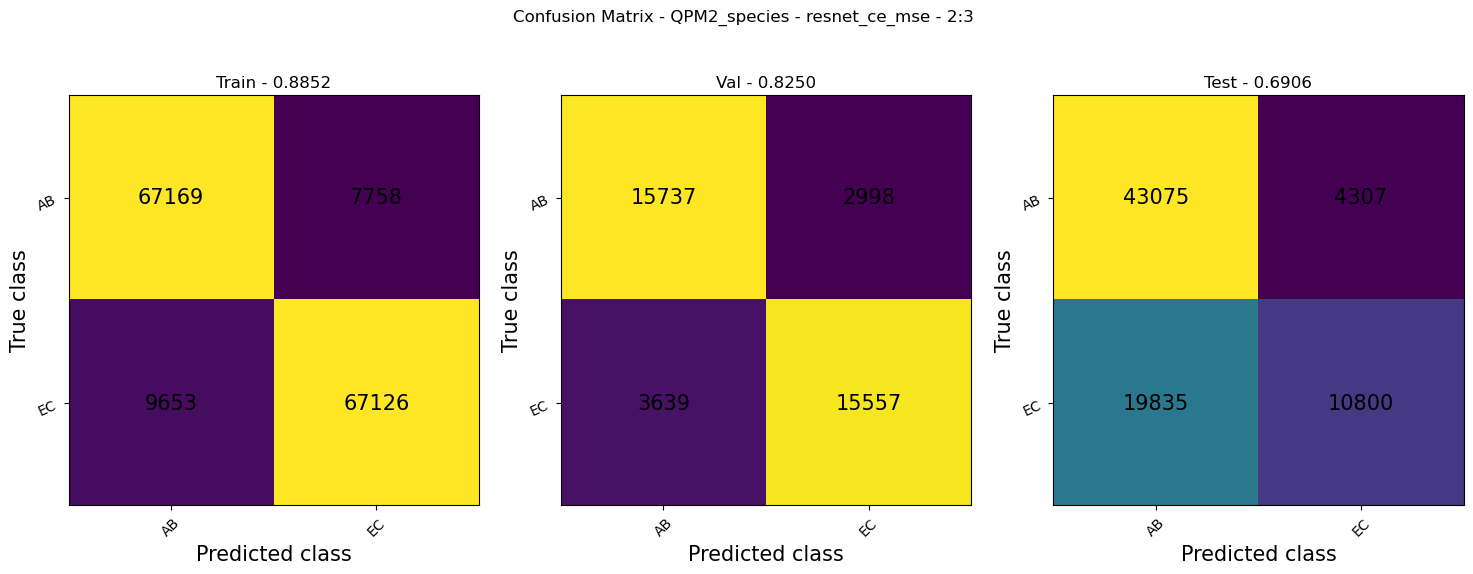

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)
(78017, 2) (81589, 2)


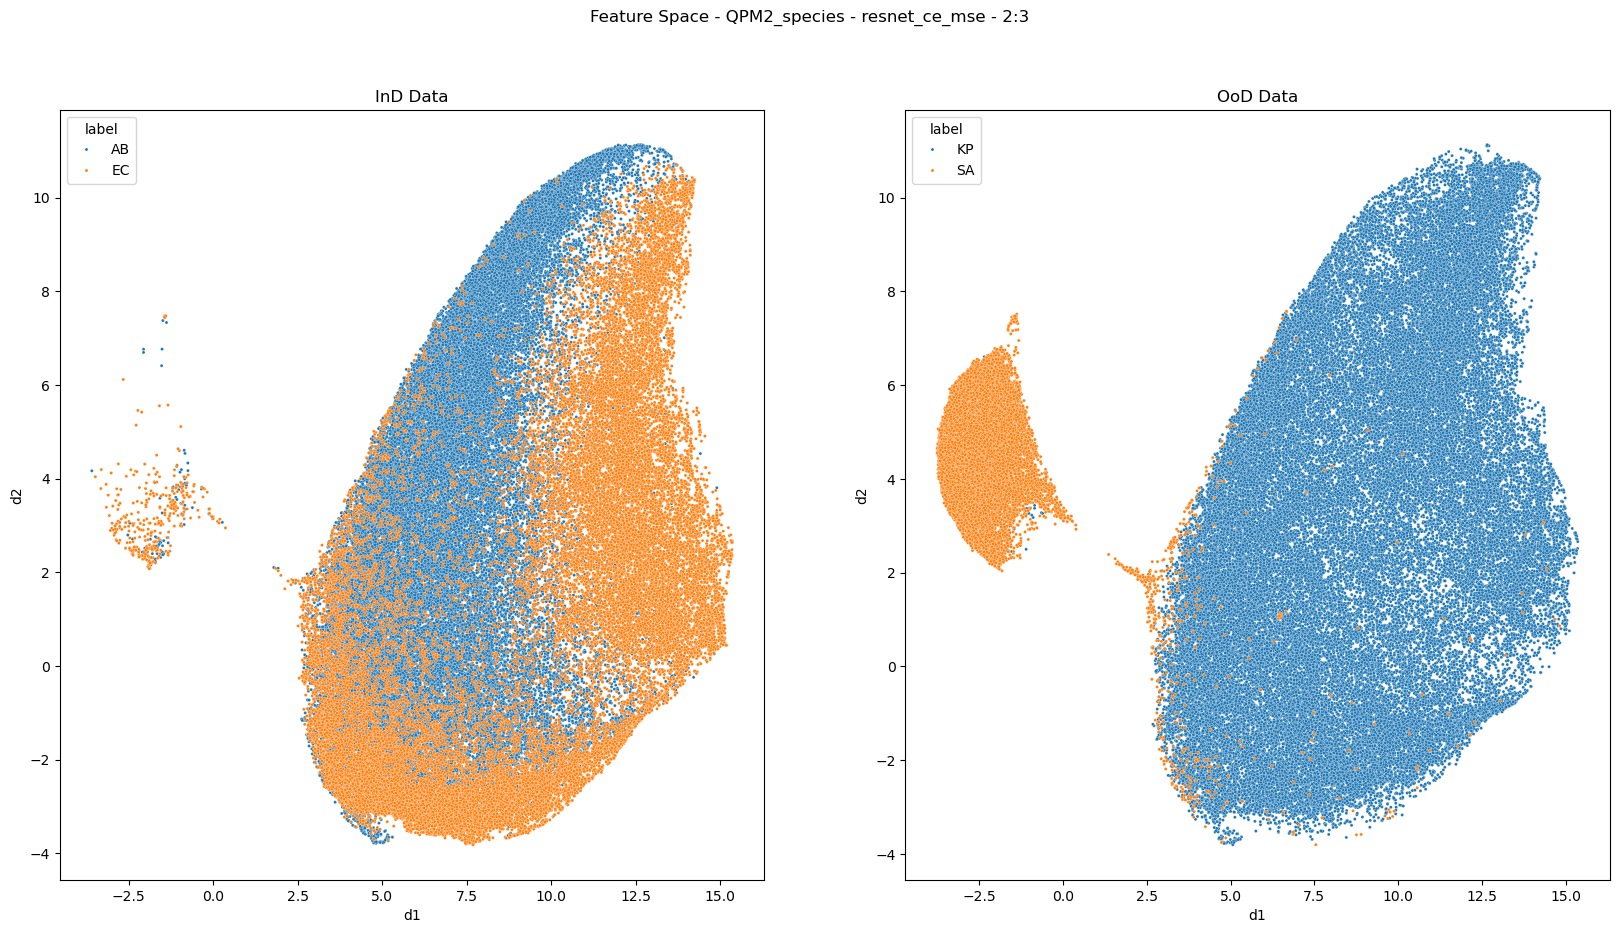

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

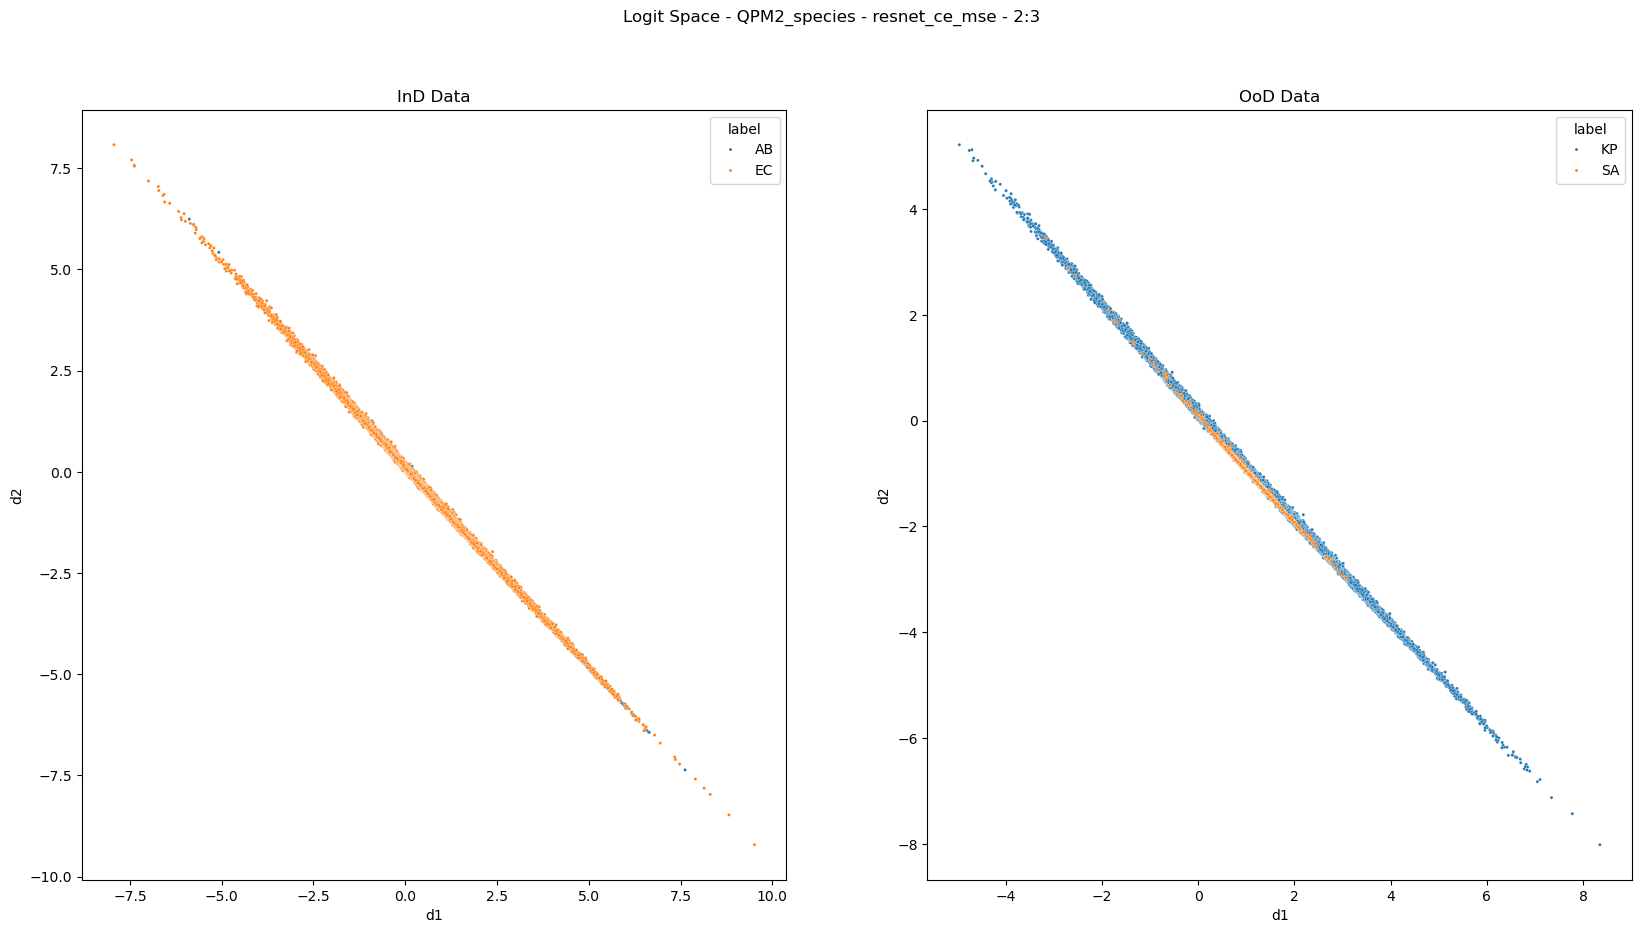

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

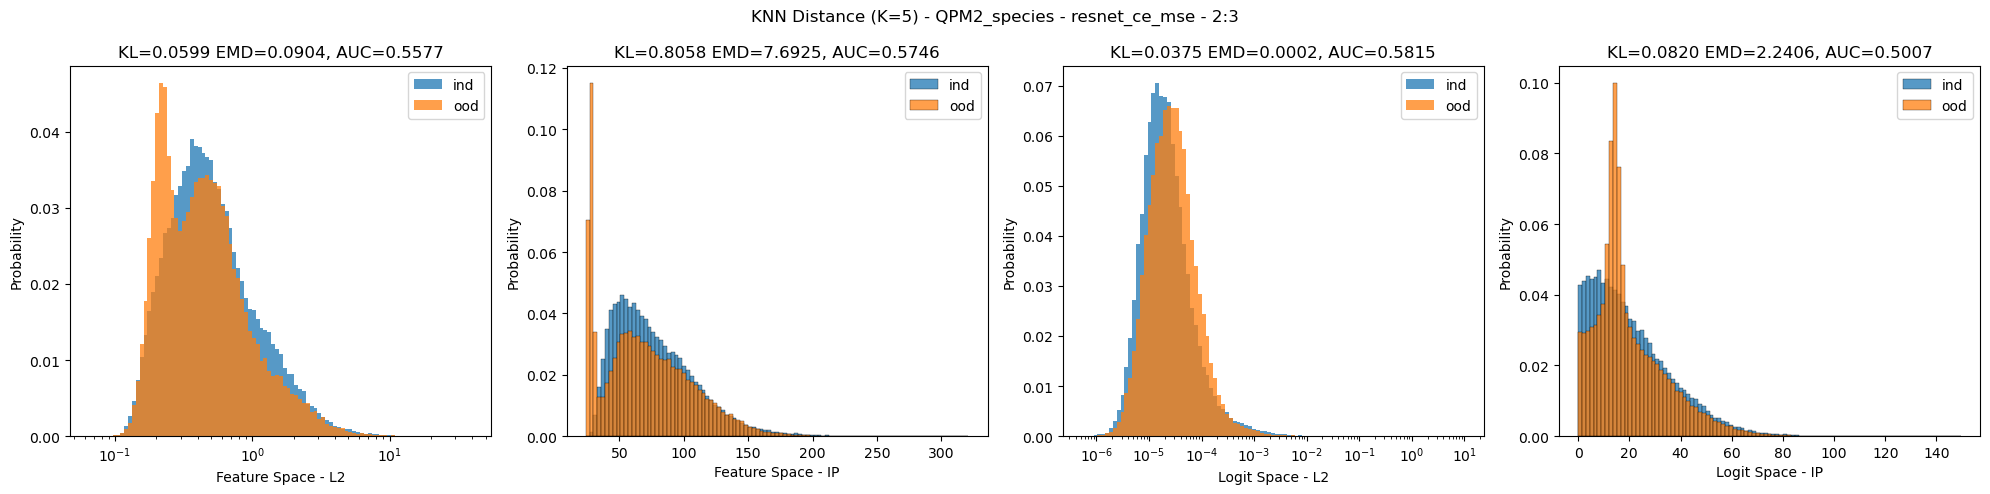

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

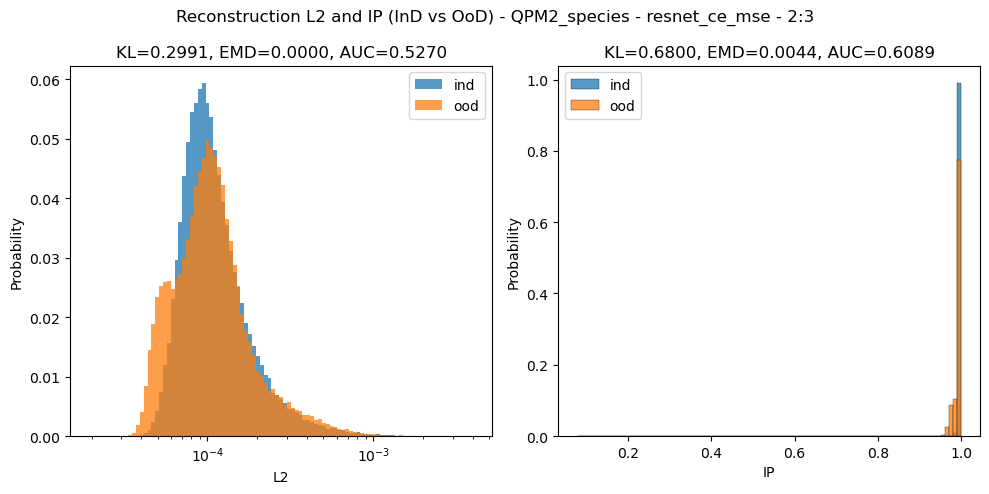

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

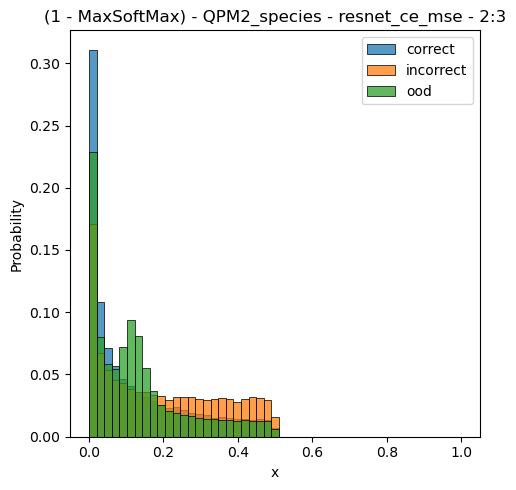

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()